In [1]:
# At the start of your notebook
from IPython.display import clear_output
import gc

# After heavy computations
clear_output(wait=True)
gc.collect()

21

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd

from utils import split_data
from datasetConstruct import combine_loaders, load_seizure_across_patients, create_dataset
from models import CNN1D, train_using_optimizer, Wavenet, LSTM, evaluate_model, output_to_probability
from plotFun import plot_time_limited_heatmap, plot_eeg_style

data_folder = "data"
MODEL_FOLDER = "checkpoints"

In [3]:
seizure_across_patients = load_seizure_across_patients('data')

ml_datasets = [create_dataset(seizure, batch_size=4096) for seizure in seizure_across_patients]

train_loader, val_loader = combine_loaders(ml_datasets, batch_size=4096)

channels, time_steps = train_loader.dataset[0][0].shape

In [4]:
# Create the model
epochs = 40
checkpoint_freq = 5
lr = 0.001 # DO NOT CHANGE!
TRAIN = False

model1 = CNN1D(input_dim=channels, kernel_size=time_steps, output_dim=2, lr=lr)
model2 = Wavenet(input_dim=channels, output_dim=2, kernel_size=time_steps, lr=lr)
model3 = LSTM(input_dim=channels, output_dim=2, lr=lr)

if TRAIN:

    # Train the model
    CNNtrain_loss, CNNval_los, CNNval_accuracy = train_using_optimizer(
                                                                        model=model1,
                                                                        trainloader=train_loader,
                                                                        valloader=val_loader,
                                                                        save_location='checkpoints',
                                                                        epochs=epochs,
                                                                        device='cuda:0',
                                                                        patience=7,
                                                                        gradient_clip=1.0,
                                                                        checkpoint_freq=checkpoint_freq
                                                                    )
    
    Wavetrain_loss, Waveval_los, Waveval_accuracy = train_using_optimizer(
                                                                            model=model2,
                                                                            trainloader=train_loader,
                                                                            valloader=val_loader,
                                                                            save_location='checkpoints',
                                                                            epochs=epochs,
                                                                            device='cuda:0',
                                                                            patience=7,
                                                                            gradient_clip=1.0,
                                                                            checkpoint_freq=checkpoint_freq
                                                                        )
    # LSTMtrain_loss, LSTMval_los, LSTMval_accuracy = train_using_optimizer(
    #                                                                         model=model3,
    #                                                                         trainloader=train_loader,
    #                                                                         valloader=val_loader,
    #                                                                         save_location='checkpoints',
    #                                                                         epochs=epochs,
    #                                                                         device='cuda:0',
    #                                                                         patience=7,
    #                                                                         gradient_clip=1.0,
    #                                                                         checkpoint_freq=checkpoint_freq
    #                                                                     )
    # 
else:
    # Load the model
    model1.load_state_dict(torch.load(os.path.join(MODEL_FOLDER, "CNN1D_best.pth"))['model_state_dict'])
    model2.load_state_dict(torch.load(os.path.join(MODEL_FOLDER, "Wavenet_best.pth"))['model_state_dict'])
    # model3.load_state_dict(torch.load(os.path.join(MODEL_FOLDER, "LSTM_best.pth")))

# Evaluate the model
loss_CNN, acuracy_CNN = evaluate_model(model1, val_loader,'cuda:0')
# loss_LSTM, acuracy_LSTM = evaluate_model(model3, val_loader,'cuda:0')
loss_Wavenet, acuracy_Wavenet = evaluate_model(model2, val_loader,'cuda:0')

C:\Users\arthu\anaconda3\envs\Code\lib\site-packages\torch\nn\modules\conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ..\aten\src\ATen\native\Convolution.cpp:1004.)
  return F.conv1d(input, weight, bias, self.stride,


In [5]:
if TRAIN:

    # Plot the loss and accuracy
    
    plt.figure()
    plt.plot(CNNtrain_loss, label="CNN Training Loss")
    # plt.plot(CNNval_los, label="CNN Validation Loss")
    plt.plot(Wavetrain_loss, label="Wavenet Training Loss")
    # plt.plot(Waveval_los, label="Wavenet Validation Loss")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss vs Epoch")
    plt.show()
    
    plt.figure()
    plt.plot(CNNval_accuracy, label="CNN Validation Accuracy")
    plt.plot(Waveval_accuracy, label="Wavenet Validation Accuracy")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Epoch")
    plt.show()


In [13]:
from utils import find_seizure_related_channels

# Load the seizure marking data
seizure_no = 1
PAT_NO = 66

seizure_marking = pd.read_excel('data/Seizure_Onset_Type_ML_USC.xlsx')

# Find the channels that have seizure marking for a given seizure number
seizure_channels, seizure_onset_channel = find_seizure_related_channels(seizure_marking, seizure_no, PAT_NO)

In [14]:
from datasetConstruct import load_single_seizure

single_seizure_folder = data_folder + f"/P{PAT_NO}"
save_folder = f"result/P{PAT_NO}/Seizure{seizure_no}"
# Get the probability of the all the dataset in a temporal matter
seizure1 = load_single_seizure(single_seizure_folder, seizure_no)

In [15]:
model = model2
model_name = model.__class__.__name__

fs = seizure1.samplingRate
seizure1_data = seizure1.ictal
seizure1_preictal = seizure1.preictal2

seizure1_data_combined = seizure1_data.reshape(-1, seizure1_data.shape[2])
seizure1_preictal_combined = seizure1_preictal

seizure1_total_con = np.concatenate((seizure1_preictal_combined, seizure1_data_combined), axis=0)

# Resample the data to 1s windows with 80% overlap
seizure1_total = split_data(seizure1_total_con, fs, overlap=0.8)

probabilities_matrix = np.zeros((seizure1_total.shape[0], seizure1_total.shape[2]))

# Feed the data to the model
for channel in range(seizure1_total.shape[2]):
    input_data = seizure1_total[:, :, channel].reshape(-1, 1, seizure1_total.shape[1])
    input_data = torch.tensor(input_data, dtype=torch.float32).to('cuda:0')
    probabilities_matrix[:, channel] = output_to_probability(model, input_data, 'cuda:0')
    

In [16]:
n_seconds = 80

# Create time axes
time_raw = np.arange(0, seizure1_total_con.shape[0]) / fs
time_prob = np.arange(0, probabilities_matrix.shape[0]) * 0.2

# Concatenate data
seizure_total = np.concatenate((seizure1_preictal_combined, 
                              seizure1_data_combined), axis=0)

print("Mean of seizure data:", np.mean(seizure1_data_combined))
print("Mean of preictal data:", np.mean(seizure1_preictal_combined))
print("Max of seizure data:", np.max(seizure1_data_combined))
print("Max of preictal data:", np.max(seizure1_preictal_combined))
print("Min of seizure data:", np.min(seizure1_data_combined))
print("Min of preictal data:", np.min(seizure1_preictal_combined))
print("Mean of seizure probability:", np.mean(probabilities_matrix))

# Plot probability data
plot_time_limited_heatmap(
    data=probabilities_matrix.T,
    time_axis=time_prob,
    n_seconds=n_seconds,
    preictal_boundary=50,
    title=f"{model_name} " + f"Probability of Seizure{seizure_no} (First {n_seconds}s)" if n_seconds else "Probability of Seizure",
    cmap='hot',
    save_path=os.path.join(save_folder, f"{model_name}Probability.png"),
    flip_yaxis=True
)

Mean of seizure data: 0.002397786021302913
Mean of preictal data: 0.002311481797853277
Max of seizure data: 59.193367686942395
Max of preictal data: 22.049402787132465
Min of seizure data: -66.96452953862514
Min of preictal data: -20.940117292782165
Mean of seizure probability: 0.6746745801504095


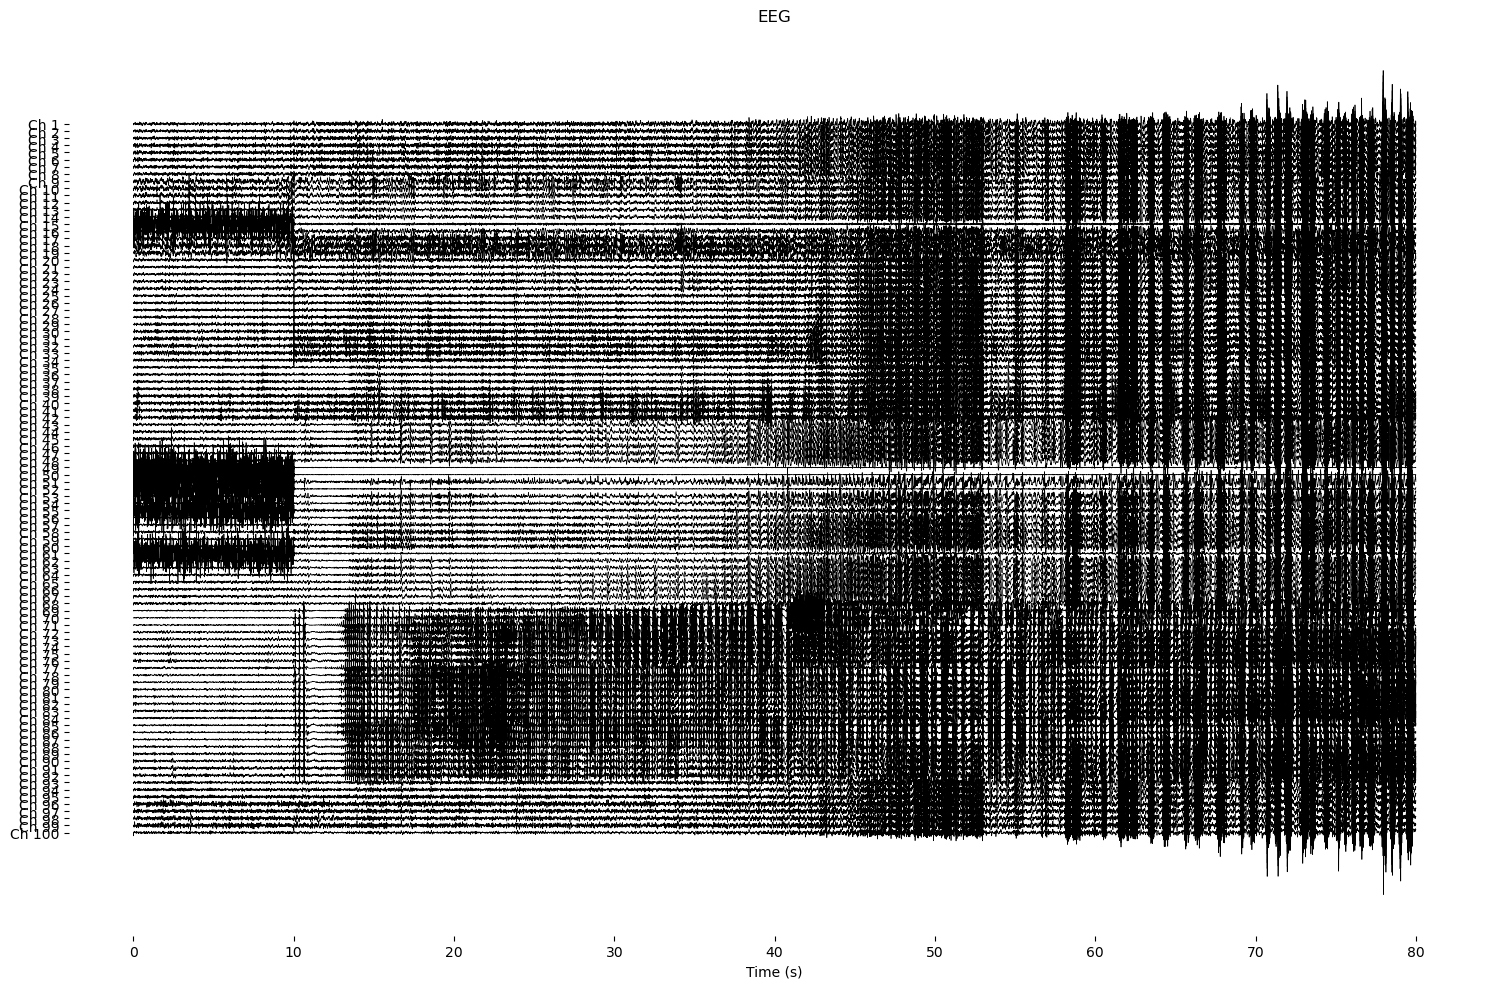

In [17]:
sub_seizure_total = seizure_total[: fs*n_seconds, :]
fig = plot_eeg_style(sub_seizure_total.T, fs, spacing_factor=2, color='black', linewidth=0.5)
fig.savefig(os.path.join(save_folder, f"Raw_EEG.png"), dpi=300, bbox_inches='tight')
plt.show()

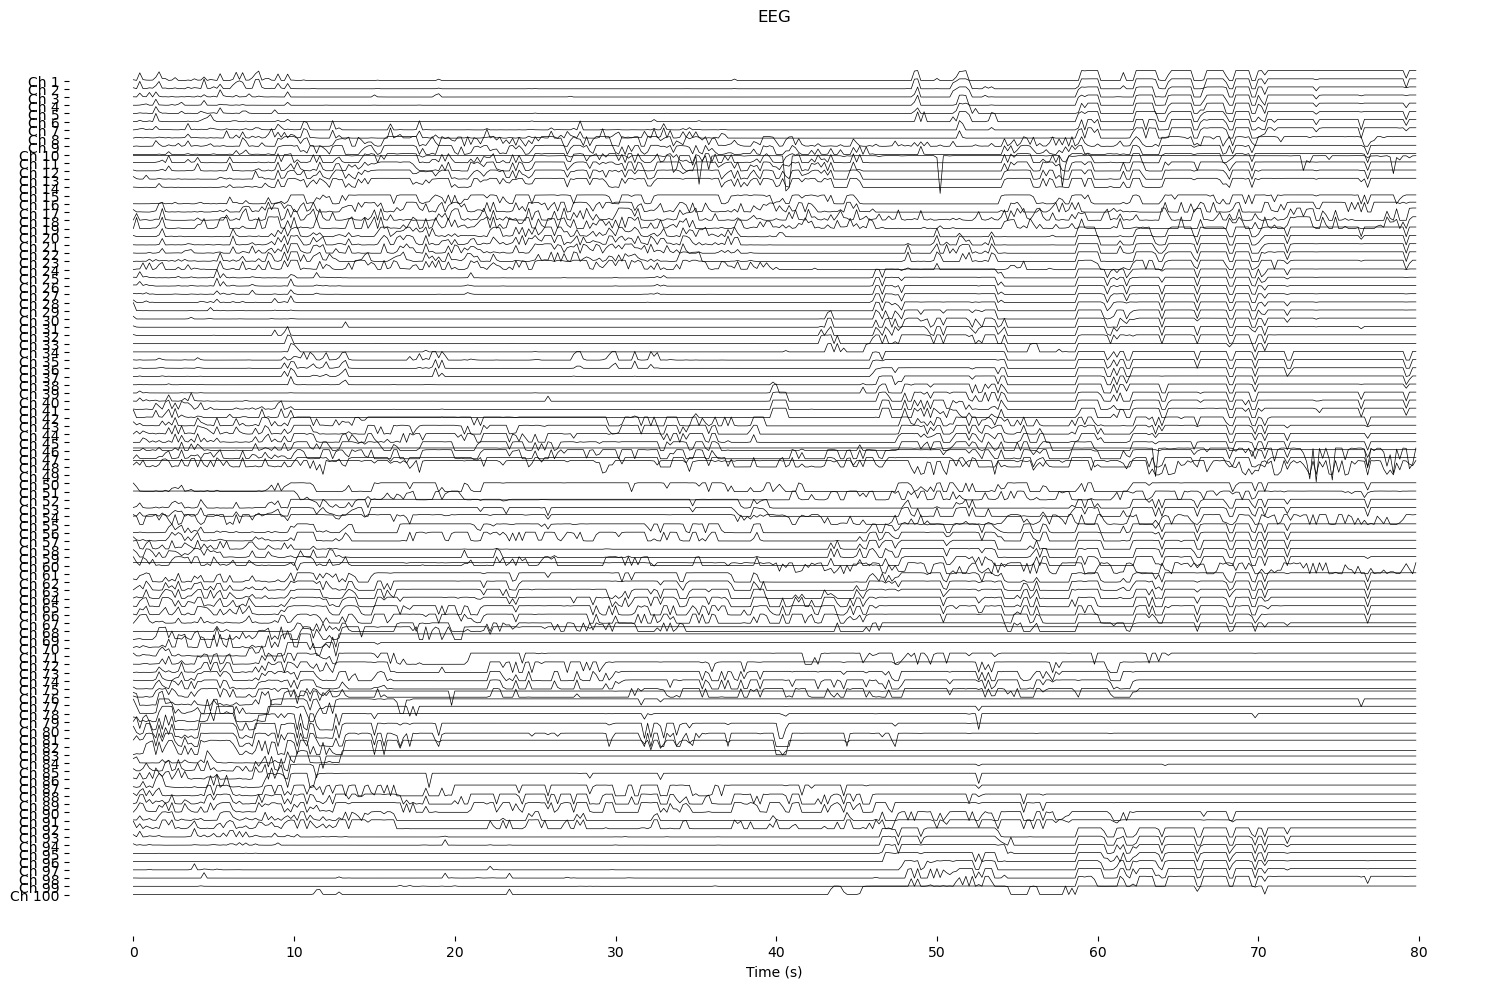

In [18]:
sub_probability_total = probabilities_matrix[: 5*n_seconds, :]
fig = plot_eeg_style(sub_probability_total.T, 5, spacing_factor=2, color='black', linewidth=0.5)
fig.savefig(os.path.join(save_folder, f"{model_name}_Probability.png"), dpi=300, bbox_inches='tight')
plt.show()

In [28]:
# Rerank the Probability Based on when the channel first reach the threshold
threshold = 0.8
# Smooth the probability data over 5 seconds, each tick is 0.2s
smooth_window = 50
n_seconds = 80
seizure_start = 10

# Smooth the probability data
probabilities_matrix_smoothed = np.zeros_like(probabilities_matrix)
for i in range(probabilities_matrix.shape[1]):
    probabilities_matrix_smoothed[:, i] = np.convolve(probabilities_matrix[:, i], 
                                                       np.ones(smooth_window) / smooth_window, 
                                                       mode='same')

# Get a section of the data when the seizure starts
probabilities_matrix_smoothed_sec = probabilities_matrix_smoothed[seizure_start * 5:, :]

# Find the first index where the probability is greater than the threshold
first_threshold_indices = np.argmax(probabilities_matrix_smoothed_sec > threshold, axis=0)
if np.sum(first_threshold_indices == 0) > 0:
    first_threshold_indices[first_threshold_indices == 0] = len(probabilities_matrix_smoothed_sec)
sorted_indices = np.argsort(first_threshold_indices)[::-1]

# Plot the probability data
plot_time_limited_heatmap(
    data=probabilities_matrix_smoothed[:, sorted_indices].T,
    time_axis=time_prob,
    n_seconds=n_seconds,
    preictal_boundary=50,
    title=f"{model_name} " + f"Probability of Seizure{seizure_no} (First {n_seconds}s) - Reranked",
    cmap='hot',
    save_path=f"{save_folder}/{model_name}ProbabilityReranked.png",
    flip_yaxis=False
)

In [36]:
# Use gridmap to output the ranked seizure channels to csv file
from utils import map_seizure_channels
channels = map_seizure_channels(sorted_indices[::-1], seizure1.gridmap)['ChannelName']

# Quantify how many channels in the first 20 channels are correctly identified based on the seizure channel
correct_channels = np.sum([channel in seizure_channels for channel in channels[:len(seizure_channels)]])/len(seizure_channels)
correct_onset_channels = np.sum([channel in seizure_onset_channel for channel in channels[:len(seizure_onset_channel)]])/len(seizure_onset_channel)